# -----------------------------------------------------
# Raiders of the Lost Plateau 
## PBC
### Created:   April 2018 
### Modified: November 2018
# -----------------------------------------------------

1. Momentum correlations are computed from simulations with a time step 0.002, while the time step is 0.004 for the
   simulations in which the correlations of the stress tensor are computed. We carefully distinguis between $dt$ and $dtStress$
2. Compute the integral of the correlations using the trapezoidal rule instead of the operator: 

  \begin{array}{cccc}
   1 & 0 & 0 & 0\\
   1 & 1 & 0 & 0\\
   1 & 1 & 1 & 0\\
   1 & 1 & 1 & 1\\
  \end{array}

# 0. STUFF

## 0.1. Packages

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import expm
from scipy import linalg
from numpy import linalg as LA
from numpy.linalg import inv
import scipy.integrate as integrate

## 0.2. Plot style

In [293]:
# Plot style
sns.set_style("whitegrid")
# Create palette
thesisPalette = ["royalblue", "darkorange", "darkmagenta", "seagreen", "deeppink", "dimgrey", "darkkhaki", "darkblue", "gold","mediumpurple", "teal"]
sns.set_palette(thesisPalette)
#Font and line width
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.0})
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)

## 0.3. Files

In [20]:
Ct          = np.loadtxt('Ct-PBC-1000steps.dat')
Sxzt        = np.loadtxt('Sxzt-PBC-1000steps.dat')
Ct_mu30nu31 = np.loadtxt('Ct-gxTh-mu30nu31')     #Correlations with support t=30
Ct_mu30nu30 = np.loadtxt('Ct-gxTh-mu30nu30')

## 0.4. Parameters

In [21]:
nSteps     = np.shape(Ct)[0]
nCols      = np.shape(Ct)[1]
nNodes     = int(np.sqrt(nCols))
nBlocks    = 1                                                            
nVar       = int(np.sqrt(nBlocks))                      
dim        = nVar * nNodes 
dt         = 0.002
dtStress   = 0.004
tol        = 1e-3
Lx, Ly, Lz = 40.0, 40.0, 30.0
Vol        = Lx * Ly * Lz
dz         = Lz / nNodes  
Temp       = 2.0
density    = 0.6

#Fourier basis and Laplacian in real and Fourier space
E    = np.zeros((nNodes, nNodes), dtype = complex)                  
EInv = np.zeros((nNodes, nNodes), dtype = complex)
for mu in range(nNodes):
    for nu in range(nNodes):
            E[mu,nu]    = np.exp( 1j*2*np.pi*mu*nu/nNodes)/np.sqrt(nNodes)
            EInv[mu,nu] = np.exp(-1j*2*np.pi*mu*nu/nNodes)/np.sqrt(nNodes)

Laplacian           = (1 / dz**2) * (-2 * (np.eye(nNodes)) +\
                    np.eye(nNodes, nNodes, -nNodes+1) + np.eye(nNodes, nNodes, nNodes-1) +\
                    np.eye(nNodes, nNodes, -1) + np.eye(nNodes, nNodes, 1))
LaplacianInv        = linalg.pinv(Laplacian, rcond = tol)
LaplacianFourier    = (EInv.dot(Laplacian).dot(E)).real 
LaplacianInvFourier = linalg.pinv(LaplacianFourier, rcond = tol)

#Forward and backward finite difference operator (for PBC)
F = (1 / dz) * ((-1) * np.eye(nNodes) +  np.eye(nNodes, nNodes, 1) + np.eye(nNodes, nNodes, -nNodes+1))
B = -F.T

## 0.5. Subroutines

In [22]:
#Reshape from vector to matrix
def reshape_vm(A):
    B = A.reshape(nBlocks,nNodes*nNodes).reshape(nVar,nVar,nNodes,nNodes).transpose(0,2,1,3).reshape(dim,dim)
    return B

#Reshape from matrix to vector
def reshape_mv(A):
    B = A.reshape(nVar,nNodes,nVar,nNodes).swapaxes(1,2).ravel()
    return B

#Select the step to which a certain time corresponds
def step(t):
    step = int(round(t/dt))
    return step   

#Select the column to which the autocorrelation of a selected node corresponds
def col(nodeSelected):
    column = (nodeSelected - 1) * nNodes + nodeSelected - 1
    return column

#Replace all values in a matrix < cutOff with zero
def cutOff(A, cutOffValue):
    rows, cols =  np.shape(A)
    B = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            #if abs(A[i,j]) < cutOffValue:
                #A[i,j] = 0
            if A[i,j] > cutOffValue:    #valor absoluto???
                B[i,j] = A[i,j]
    return B

#Replace all values in a matrix equal to zero with NaN 
def zeroToNan(A):
    rows, cols =  np.shape(A)
    for i in range(rows):
        for j in range(cols):
            if A[i,j] == 0:
                A[i,j] = np.nan
    return A

#Take advantage of the PBC for building C(t). Las matrices que cargo
#ya han pasado por este incremento de estadística. Dejo aquí la 
#subrutina por si acaso. 
def pbc(C):
    Cstat = np.zeros((nNodes, nNodes))
    for i in range(nNodes):
        for j in range(nNodes):
            for k in range(nNodes):
                Cstat[i,j] += C[(i+k)%nNodes,(j+k)%nNodes]
    return Cstat/nNodes 

#Smooth C(t)
P = np.eye(nNodes)
for i in np.arange(1,15,1):
    P +=  np.eye(nNodes, nNodes, -nNodes+i) + np.eye(nNodes, nNodes, nNodes-i) +\
    np.eye(nNodes, nNodes, -i) + np.eye(nNodes, nNodes, i)
def smooth(A):
    B = (A + 2.5e-5) * P - 2.5e-5    #Eq.(84) paper Space and time locality of discrete hydrodynamics
    C = B + 4.39991076e-5 / nNodes   #Modification to obtain total momentum equal to zero. P_T=0.
    return C

#Derivative and integral operators. The derivative is in compliance with the Barrow rule.
ODev      = np.identity(nSteps) - np.eye(nSteps, nSteps, -1) 
OInt      = np.tril(np.ones((nSteps, nSteps), dtype=float), 0) 
ODev[0,0] = 0
ODev /= dt
OInt *= dt

## 0.6. Smooth $C(t)$ and convert it to an array of 3 dimensions

In [23]:
CtSmooth = np.zeros((nSteps, nNodes**2))
for i in range(nSteps):
    CtSmooth[i:] = reshape_mv(smooth(reshape_vm(Ct[i,:])))
Ct = CtSmooth

Ct3D = np.zeros((nNodes, nNodes, nSteps))
for i in range(nSteps):
    Ct3D[:,:,i] = reshape_vm(Ct[i,:])   
Ct = Ct3D

C0 = Ct[:,:,0]
R = linalg.pinv(C0, rcond = tol)

# 1. REAL SPACE

## 1.1. Compute $\dot{C}_{\mu\nu}(t)$, $C^{-1}_{\mu\nu}(t)$ and $\Lambda_{\mu\nu}(t)$

In [24]:
CtDev     = np.zeros((nNodes, nNodes, nSteps))
CtInv     = np.zeros((nNodes, nNodes, nSteps))
CtNorm    = np.zeros((nNodes, nNodes, nSteps))
CtNormInv = np.zeros((nNodes, nNodes, nSteps))
Lambdat   = np.zeros((nNodes, nNodes, nSteps))

for i in range(nNodes):
    CtDev[i,:,:] = ODev.dot(Ct[i,:,:].T).T
    
for k in range(nSteps):
    CtInv[:,:,k]     = linalg.pinv(Ct[:,:,k], rcond = tol)
    CtNorm[:,:,k]    = R.dot(Ct[:,:,k])
    CtNormInv[:,:,k] = linalg.pinv(CtNorm[:,:,k], rcond = tol)
    Lambdat[:,:,k]   = - CtDev[:,:,k].dot(CtInv[:,:,k])

#### Plot $C_{\mu\nu}(t)$, $\dot{C}_{\mu\nu}(t)$, $C^{-1}_{\mu\nu}(t)$  and $\Lambda_{\mu\nu}(t)$

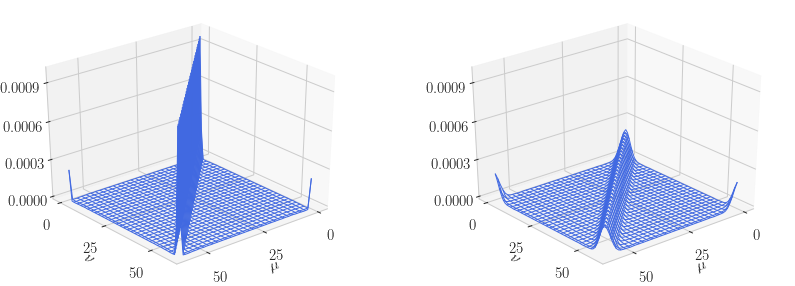

In [281]:
# Select the correct size of the plot
fig = plt.figure()
fig.set_size_inches(14,11)

x = range(nNodes)
y = range(nNodes)

p = 1
for t in np.arange(0, 0.7, 0.6):

    h = fig.add_subplot(2,2,p, projection='3d')
    X, Y = np.meshgrid(x, y) 
    h.plot_wireframe(X, Y, Ct[:,:,step(t)])
    h.set_zlim(0,1e-3)
    h.set_xticks(range(0, 59, 25))
    h.set_yticks(range(0, 59, 25))
    h.set_zticks(np.arange(0, 1e-3, 0.0003))
    #h.set_title(r'$\rm{C_{\mu\nu}('+str(t)+')}$')
    h.set_xlabel(r'$\rm{\mu}$')
    h.set_ylabel(r'$\rm{\nu}$')
    h.view_init(30, 50)
    p += 1       
#plt.savefig('/Users/diego/Desktop/Thesis/figures/Ct-matrix-PBC.pdf'#This is simple recomendation for publication plots
#            ,dpi=1000, 
#            # Plot will be occupy a maximum of available space
#            bbox_inches='tight') 
plt.show()

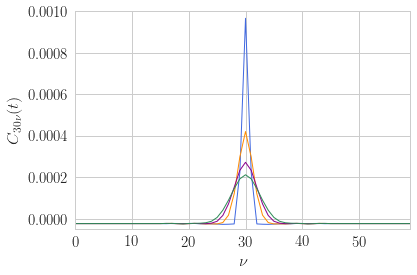

In [295]:
plt.plot(Ct[30,:,step(0)],   label = r'${C(0)_{30\nu}')
plt.plot(Ct[30,:,step(0.2)], label = r'${C(0.2)_{30\nu}')
plt.plot(Ct[30,:,step(0.4)], label = r'${C(0.4)_{30\nu}')
plt.plot(Ct[30,:,step(0.6)], label = r'${C(0.6)_{30\nu}')
plt.xlim(0,59)
plt.ylim(-5e-5,1e-3)
plt.xlabel(r'$\nu$')
plt.ylabel(r'$C_{30\nu}(t)$')
#plt.legend()
#plt.savefig('/Users/diego/Desktop/Thesis/figures/Ct-mu30nu-PBC.pdf',dpi=1000, bbox_inches='tight')  
plt.show()

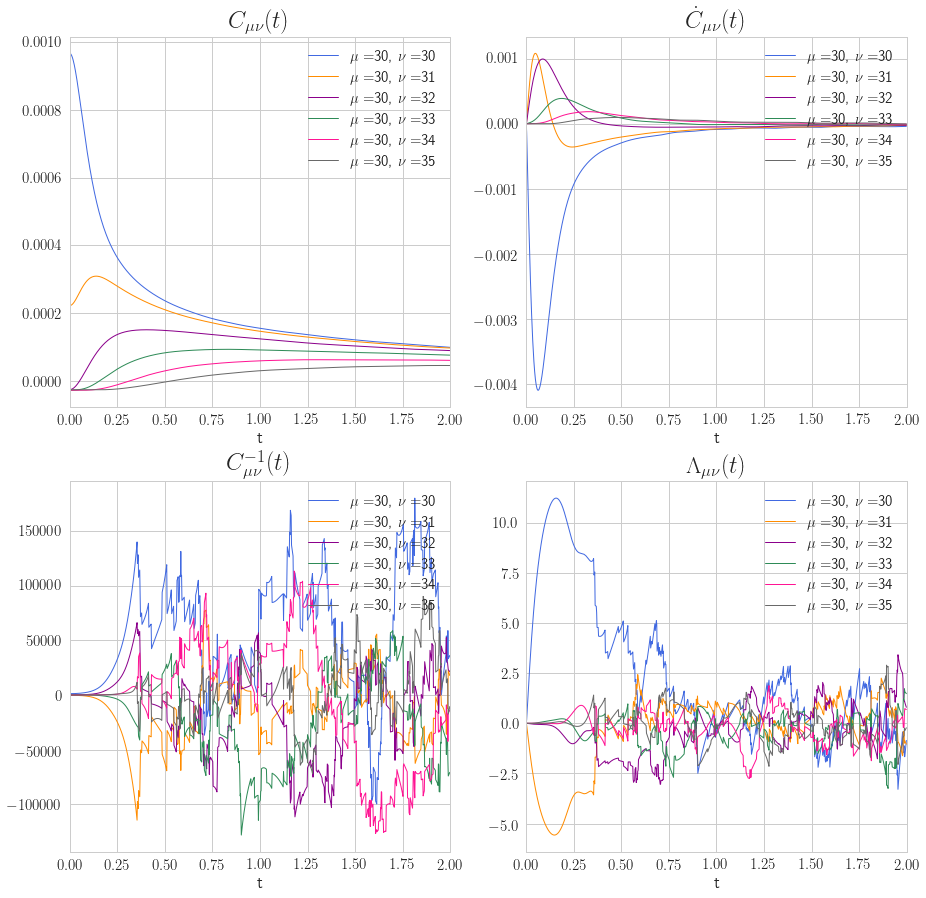

In [296]:
x  = np.arange(0, nSteps*dt, dt)
plt.figure(1, figsize=(15,15))

plt.subplot(221)
for i in range(6):
    plt.plot(x, Ct[30, 30 + i, :], label = r'$\mu=$'+str(30)+r', $\nu=$'+str(30+i))
plt.xlim(0,2)
plt.title(r'$C_{\mu \nu}(t)$', fontsize = 24)
plt.xlabel('t')
plt.legend(loc='upper right')

plt.subplot(222)
#f  = plt.figure(figsize=(15,13))
for i in range(6):
    plt.plot(x, CtDev[30, 30 + i, :], label = r'$\mu=$'+str(30)+r', $\nu=$'+str(30+i))
plt.xlim(0,2)
plt.title(r'$\dot{C}_{\mu \nu}(t)$', fontsize = 24)
plt.xlabel('t')
plt.legend(loc='upper right')

plt.subplot(223)
for i in range(6):
    plt.plot(x, CtInv[30, 30 + i, :], label = r'$\mu=$'+str(30)+r', $\nu=$'+str(30+i))
plt.xlim(0,2)
plt.title(r'$C_{\mu \nu}^{-1}(t)$', fontsize = 24)
plt.xlabel('t')
plt.legend(loc='upper right')


plt.subplot(224)
for i in range(6):
    plt.plot(x, Lambdat[30, 30 + i, :], label = r'$\mu=$'+str(30)+r', $\nu=$'+str(30+i))
plt.xlim(0,2)
plt.title(r'$\Lambda_{\mu \nu}(t)$', fontsize = 24)
plt.xlabel('t')
plt.legend(loc='upper right')
plt.show()

## 1.2. Compute $\eta_{\mu\nu}(t)$ and $\nu_{\mu\nu}(t)$

In [135]:
Etat     = np.zeros((nNodes, nNodes, nSteps))
KinVisct = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    Etat[:,:,k]     = reshape_vm(np.trapz(Sxzt[0:k+1,:], dx=dtStress, axis=0))
    KinVisct[:,:,k] = -LaplacianInv.dot(Lambdat[:,:,k])
Etat /= Temp

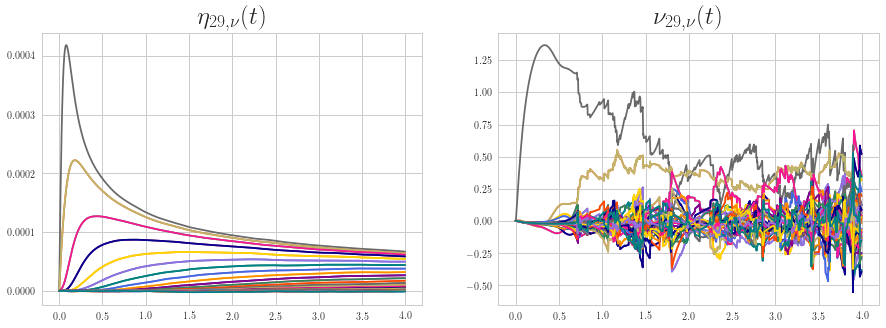

In [149]:
x = np.arange(0,nSteps*dtStress,dtStress)
plt.figure(1, figsize=(15,5))

plt.subplot(121)
for i in range(nNodes):
    plt.plot(x, Etat[29,i,:])
plt.title(r'$\eta_{29,\nu}(t)$', fontsize=25)

plt.subplot(122)
for i in range(nNodes):
    plt.plot(x, KinVisct[29,i,:])
plt.title(r'$\nu_{29,\nu}(t)$', fontsize=25)
plt.show()

#### Save files

# 2. FOURIER SPACE

## 2.1. Compute $\tilde{C}(t)_{\mu\nu}$, $\tilde{\dot{C}}_{\mu\nu}(t)$, $\tilde{C}^{-1}_{\mu\nu}(t)$, $\tilde{\Lambda}_{\mu\nu}(t)$, $\tilde{\nu}_{\mu\nu}$, $\tilde{\eta}_{\mu\nu}$ , $\tilde{\eta}^*_{\mu\nu}$, and $\eta^*(t)$

$\tilde{\eta}^*(t)=\frac{1}{k_BT\tilde{\Delta}\tilde{c}(t)}\frac{d\tilde{C}}{dt}$

$\tilde{\eta}_2^*(t)=\frac{\tilde{\eta}(t)}{\tilde{c}(t)}$

In [150]:
CtFourier        = np.zeros((nNodes, nNodes, nSteps))
CtNormFourier    = np.zeros((nNodes, nNodes, nSteps))
CtNormInvFourier = np.zeros((nNodes, nNodes, nSteps))
CtDevFourier     = np.zeros((nNodes, nNodes, nSteps))
CtInvFourier     = np.zeros((nNodes, nNodes, nSteps))
LambdatFourier   = np.zeros((nNodes, nNodes, nSteps))
KinVisctFourier  = np.zeros((nNodes, nNodes, nSteps))
EtatFourier      = np.zeros((nNodes, nNodes, nSteps))
EtaStartFourier  = np.zeros((nNodes, nNodes, nSteps))
EtaStartFourier2 = np.zeros((nNodes, nNodes, nSteps))
EtaStart         = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    CtFourier[:,:,k] = (EInv.dot(Ct[:,:,k]).dot(E)).real

C0Fourier = CtFourier[:,:,0]
RFourier  = linalg.pinv(C0Fourier, rcond = tol)

for i in range(nNodes):
    CtDevFourier[i,:,:] = ODev.dot(CtFourier[i,:,:].T).T

for k in range(nSteps):
    CtNormFourier[:,:,k]    = RFourier.dot(CtFourier[:,:,k])
    CtInvFourier[:,:,k]     = linalg.pinv(CtFourier[:,:,k], rcond = tol)
    CtNormInvFourier[:,:,k] = CtInvFourier[:,:,k].dot(C0Fourier)
    LambdatFourier[:,:,k]   = - CtDevFourier[:,:,k].dot(CtInvFourier[:,:,k])
    KinVisctFourier[:,:,k]  = - LaplacianInvFourier.dot(LambdatFourier[:,:,k])
    EtatFourier[:,:,k]      = (EInv.dot(Etat[:,:,k]).dot(E)).real
    EtaStartFourier[:,:,k]  = (1.0 / Temp) * \
                (LaplacianInvFourier.dot(CtFourier[:,:,0]).dot(CtInvFourier[:,:,k]).dot(CtDevFourier[:,:,k]))
    EtaStartFourier[0,0,k]  = (1.0 / nNodes) * np.sum(Etat[:,:,k])  # From (41) in Space and time locality...
    EtaStart[:,:,k] = E.dot(EtaStartFourier[:,:,k]).dot(EInv)      

for k in range(nSteps/2):
    EtaStartFourier2[:,:,k] = EtatFourier[:,:,k].dot(CtNormInvFourier[:,:,2 * k])

for k in range(nSteps/2):
    EtaStartFourier2[0,0,k] = (1.0 / nNodes) * np.sum(Etat[:,:,k])  # From (41) in Space and time locality...

/Users/diego/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


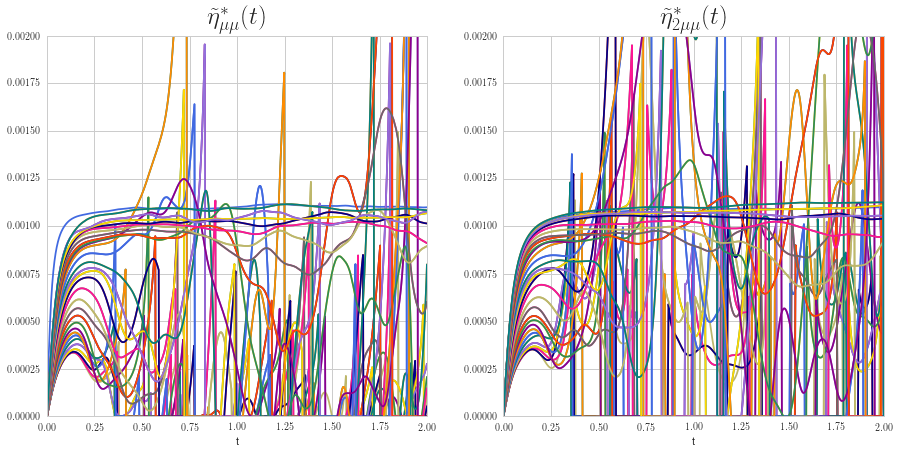

In [151]:
plt.figure(1, figsize=(15,7))

plt.subplot(121)
x = np.arange(0, nSteps * dt, dt)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier[i,i,:])
plt.title(r'$\tilde{\eta}^*_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.002)

plt.subplot(122)
x = np.arange(0, nSteps * dtStress, dtStress)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier2[i,i,:])
plt.title(r'$\tilde{\eta}^*_{2\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.002)
plt.show()

#### The same after chopping the matrix $\tilde{C}(t)$ $\to$ $\bar{\tilde{C}}(t)$

In [152]:
cutOffValue = 2e-5
CtFourierChop        = np.zeros((nNodes, nNodes, nSteps))
CtNormFourierChop    = np.zeros((nNodes, nNodes, nSteps))
CtNormInvFourierChop = np.zeros((nNodes, nNodes, nSteps))
CtDevFourierChop     = np.zeros((nNodes, nNodes, nSteps))
CtInvFourierChop     = np.zeros((nNodes, nNodes, nSteps))
LambdatFourierChop   = np.zeros((nNodes, nNodes, nSteps))
KinVisctFourierChop  = np.zeros((nNodes, nNodes, nSteps))
EtaStartFourierChop  = np.zeros((nNodes, nNodes, nSteps))
EtaStartFourier2Chop = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    CtFourierChop[:,:,k] = cutOff((CtFourier[:,:,k]), cutOffValue)

for i in range(nNodes):
    CtDevFourierChop[i,:,:] = ODev.dot(CtFourierChop[i,:,:].T).T

for k in range(nSteps):
    CtInvFourierChop[:,:,k]     = linalg.pinv(CtFourierChop[:,:,k], rcond = tol)
    CtNormFourierChop[:,:,k]    = CtInvFourierChop[:,:,0].dot(CtFourierChop[:,:,k])
    CtNormInvFourierChop[:,:,k] = CtInvFourierChop[:,:,k].dot(CtFourierChop[:,:,0])
    LambdatFourierChop[:,:,k]   = - CtDevFourierChop[:,:,k].dot(CtInvFourierChop[:,:,k])
    KinVisctFourierChop[:,:,k]  = - LaplacianInvFourier.dot(LambdatFourierChop[:,:,k])
    EtaStartFourierChop[:,:,k]  = (1 / Temp) * \
            (LaplacianInvFourier.dot(CtFourierChop[:,:,0]).dot(CtInvFourierChop[:,:,k]).dot(CtDevFourierChop[:,:,k]))

#Como el paso de tiempo en el cálculo de las correlaciones del momento es 0.002 y el de las correlaciones del tensor
#de tensiones es 0.004, hay que tener cuidado cuando se multiple una variable que está obtenida a partir del tensor
#de tensiones por otra que provenga de las correlaciones del momento. 
for k in range(nSteps/2):
    EtaStartFourier2Chop[:,:,k] = EtatFourier[:,:,k].dot(CtNormInvFourierChop[:,:,2*k])

#Convert zeros to NaN's 
for k in range(nSteps):
    CtFourierChop[:,:,k]        = zeroToNan(CtFourierChop[:,:,k])
    CtNormFourierChop[:,:,k]    = zeroToNan(CtNormFourierChop[:,:,k])
    CtDevFourierChop[:,:,k]     = zeroToNan(CtDevFourierChop[:,:,k])
    CtInvFourierChop[:,:,k]     = zeroToNan(CtInvFourierChop[:,:,k])
    LambdatFourierChop[:,:,k]   = zeroToNan(LambdatFourierChop[:,:,k])
    KinVisctFourierChop[:,:,k]  = zeroToNan(KinVisctFourierChop[:,:,k])
    EtaStartFourierChop[:,:,k]  = zeroToNan(EtaStartFourierChop[:,:,k])
    EtaStartFourier2Chop[:,:,k] = zeroToNan(EtaStartFourier2Chop[:,:,k])

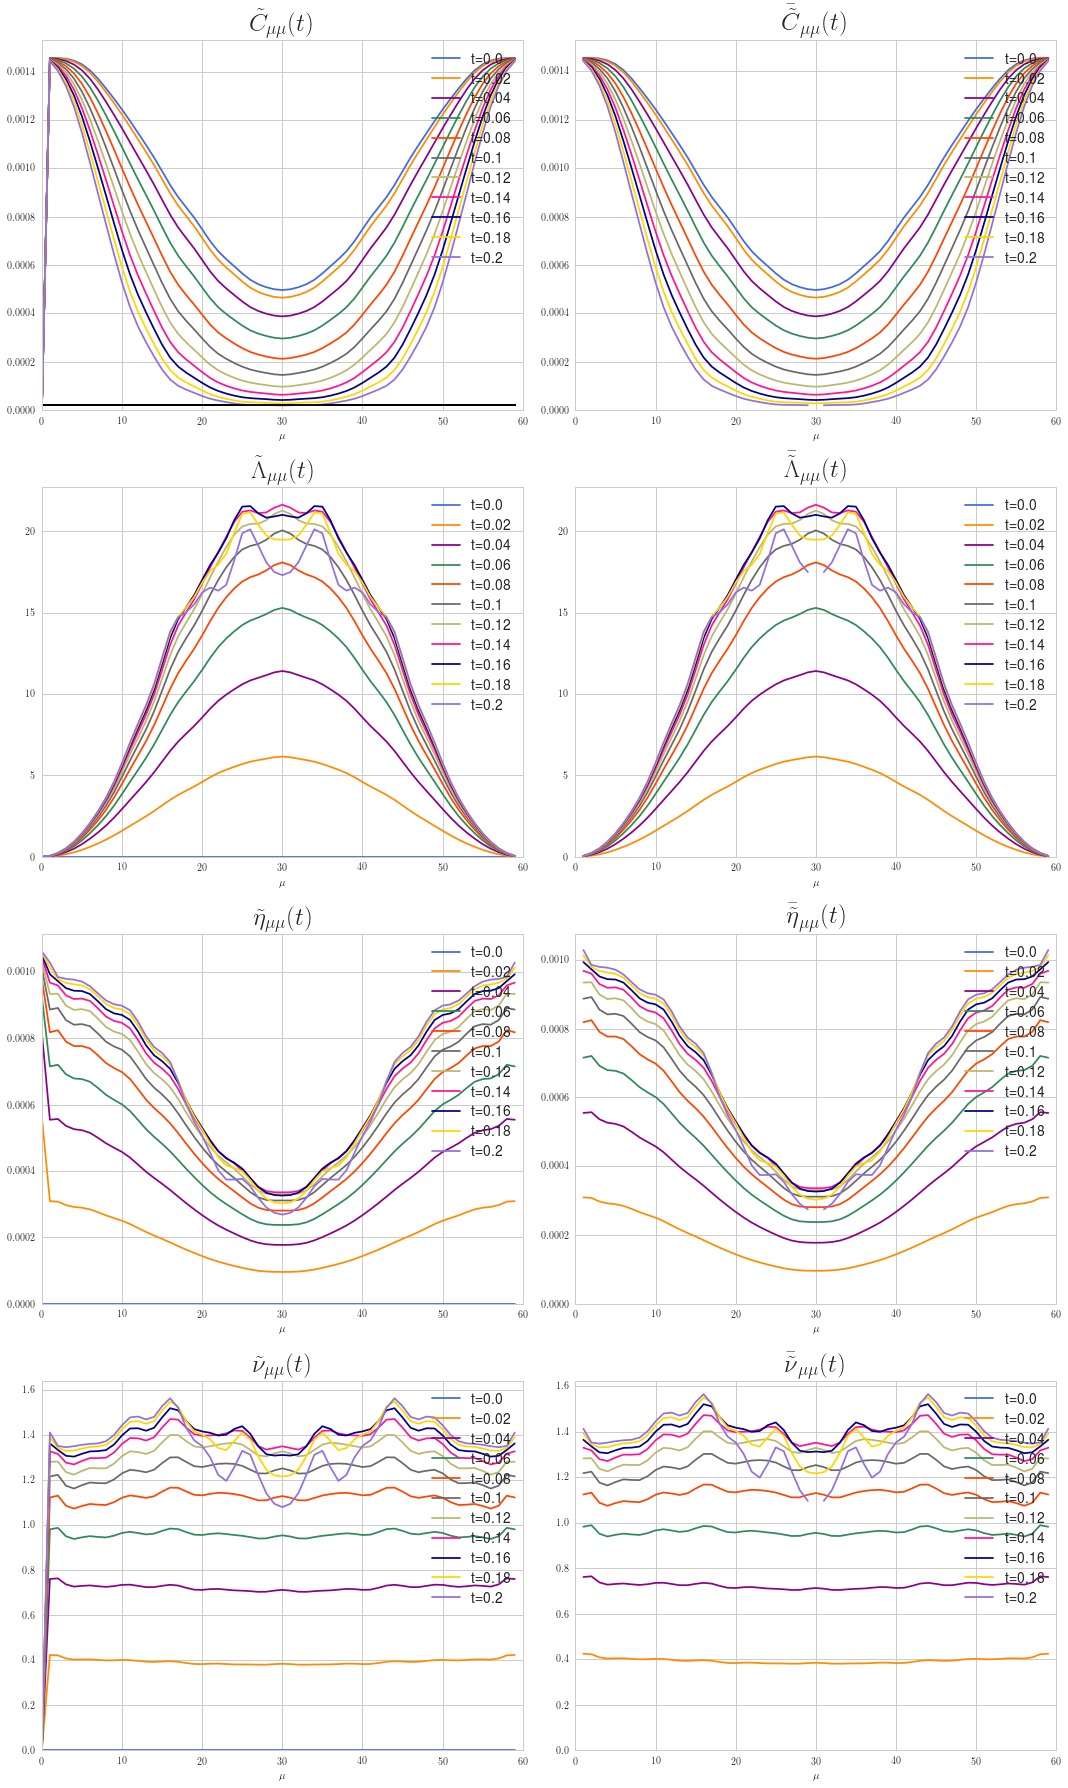

In [153]:
x = range(nNodes)

tStart, tStop, tJump = 0, 0.22, 0.02

plt.figure(1, figsize=(15,25))

plt.subplot(421)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(CtFourier[:,:,step(t)]), label = 't='+str(t)) 
    plt.plot(x, np.ones(nNodes) * cutOffValue, 'k')
plt.title(r'$\tilde{C}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(422)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(CtFourierChop[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\bar{\tilde{C}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(423)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(LambdatFourier[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\tilde{\Lambda}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(424)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(LambdatFourierChop[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\bar{\tilde{\Lambda}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(425)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(EtaStartFourier[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\tilde{\eta}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(426)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(EtaStartFourierChop[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\bar{\tilde{\eta}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(427)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(KinVisctFourier[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\tilde{\nu}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(428)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(KinVisctFourierChop[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\bar{\tilde{\nu}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.tight_layout() #Improve spacing between subplots
plt.show()

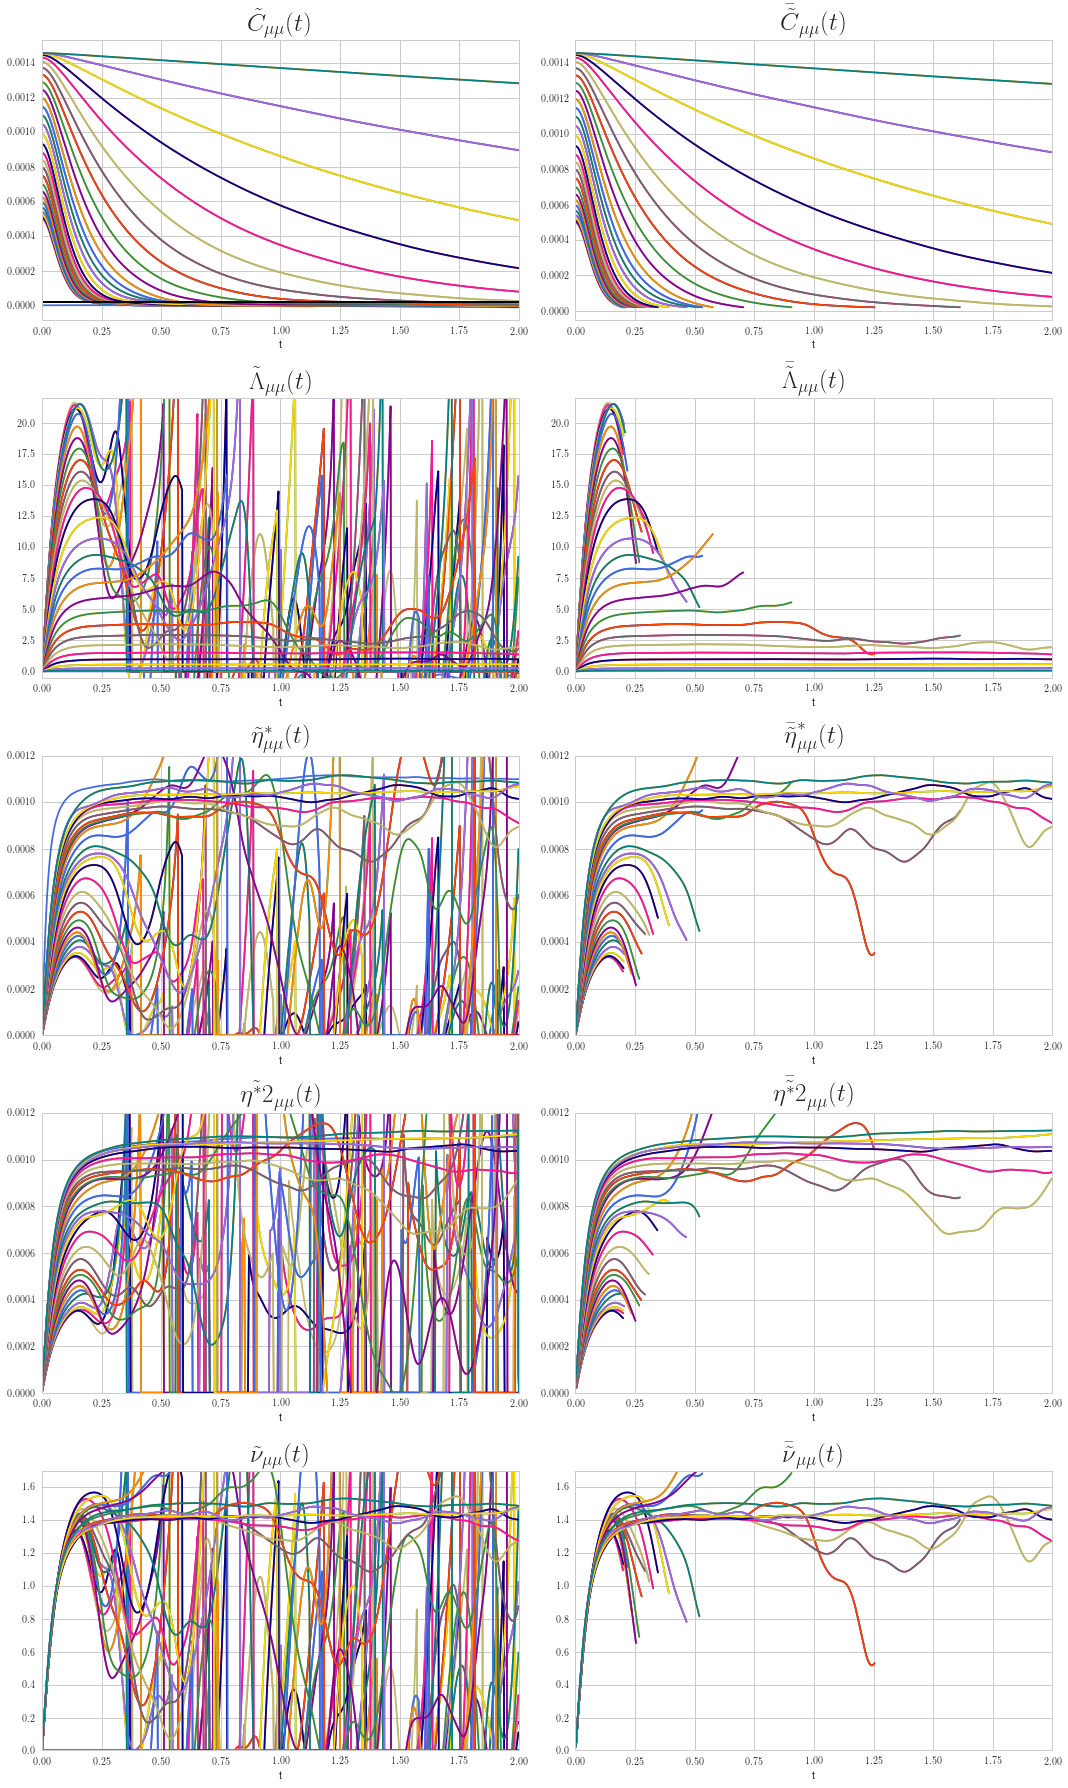

In [154]:
x = np.arange(0, nSteps * dt, dt)

plt.figure(1, figsize=(15,25))

plt.subplot(521)
for i in range(nNodes):
    plt.plot(x, CtFourier[i,i,:])
    plt.plot(x, np.ones(nSteps) * cutOffValue, 'k')
plt.title(r'$\tilde{C}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)

plt.subplot(522)
for i in range(nNodes):
    plt.plot(x, CtFourierChop[i,i,:])
plt.title(r'$\bar{\tilde{C}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)

plt.subplot(523)
for i in range(nNodes):
    plt.plot(x, LambdatFourier[i,i,:])
plt.title(r'$\tilde{\Lambda}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(-0.5,22)

plt.subplot(524)
for i in range(nNodes):
    plt.plot(x, LambdatFourierChop[i,i,:])
plt.title(r'$\bar{\tilde{\Lambda}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(-0.5,22)

plt.subplot(525)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier[i,i,:])
plt.title(r'$\tilde{\eta}^*_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.0012)

plt.subplot(526)
for i in range(nNodes):
    plt.plot(x, EtaStartFourierChop[i,i,:])
plt.title(r'$\bar{\tilde{\eta}}^*_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.0012)

x = np.arange(0, nSteps * dtStress, dtStress)
plt.subplot(527)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier2[i,i,:])
plt.title(r'$\tilde{\eta^*2}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.0012)

plt.subplot(528)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier2Chop[i,i,:])
plt.title(r'$\bar{\tilde{\eta^*2}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.0012)

x = np.arange(0, nSteps * dt, dt)
plt.subplot(529)
for i in range(nNodes):
    plt.plot(x, KinVisctFourier[i,i,:])
plt.title(r'$\tilde{\nu}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,1.7)

plt.subplot(5,2,10)
for i in range(nNodes):
    plt.plot(x, KinVisctFourierChop[i,i,:])
plt.title(r'$\bar{\tilde{\nu}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,1.7)

plt.tight_layout() #Improve spacing between subplots
plt.show()

#### Save files

## 2.2. Compare $\eta^*(\tau)$ and $\eta(\tau)$

In [156]:
plt.plot(Etat[29,:,step(0.2)],     label = r'${\eta(\tau)}_{29\nu}')
plt.plot(EtaStart[29,:,step(0.2)], label = r'${\eta^*(\tau)}_{29\nu}')
plt.legend()
plt.show()

RuntimeError: LaTeX was not able to process the following string:
'${\\\\eta^*(\\\\tau)}_{29\\\\nu}'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/MacPorts 2017_2) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./aa87dfcc6c48ae83275051fd3c86c711.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 46 language(s) loaded.
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))
(/opt/local/share/texmf-texlive/tex/latex/type1cm/type1cm.sty)
(/opt/local/share/texmf-texlive/tex/latex/psnfss/helvet.sty
(/opt/local/share/texmf-texlive/tex/latex/graphics/keyval.sty))
(/opt/local/share/texmf-texlive/tex/latex/base/textcomp.sty
(/opt/local/share/texmf-texlive/tex/latex/base/ts1enc.def))
(/opt/local/share/texmf-texlive/tex/latex/geometry/geometry.sty
(/opt/local/share/texmf-texlive/tex/generic/oberdiek/ifpdf.sty)
(/opt/local/share/texmf-texlive/tex/generic/oberdiek/ifvtex.sty)
(/opt/local/share/texmf-texlive/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file aa87dfcc6c48ae83275051fd3c86c711.aux.
(/opt/local/share/texmf-texlive/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/opt/local/share/texmf-texlive/tex/latex/psnfss/ot1phv.fd)
! Extra }, or forgotten $.
l.12 ...500000}{\sffamily ${\eta^*(\tau)}_{29\nu}}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./aa87dfcc6c48ae83275051fd3c86c711.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on aa87dfcc6c48ae83275051fd3c86c711.dvi (1 page, 448 bytes).
Transcript written on aa87dfcc6c48ae83275051fd3c86c711.log.
 



## 2.3. Compute $\tilde{\Lambda}_{\mu\mu}^{\rm loc}$ and compare with $\tilde{\Lambda}_{\mu\mu}$ 

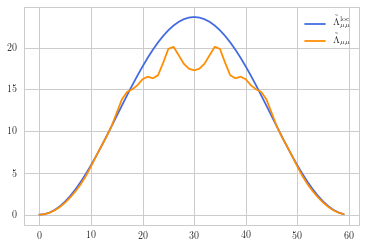

In [157]:
LambdaLoc = np.zeros(nNodes)
for i in range(nNodes):
    LambdaLoc[i] = 2 / dz**2 * (1-np.cos(2*np.pi*i/nNodes)) * 1.48

plt.plot(LambdaLoc, label = r'$\tilde{\Lambda}_{\mu\mu}^{\rm loc}$')
plt.plot(np.diag(LambdatFourier[:,:,step(0.2)]), label = r'$\tilde{\Lambda}_{\mu\mu}$')
plt.legend()
plt.show()

In [158]:
LambdaCompare = np.zeros((nNodes,2))
LambdaCompare[:,0] = np.diag(LambdatFourier[:,:,step(0.2)])
LambdaCompare[:,1] = LambdaLoc

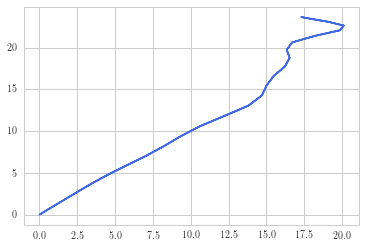

In [159]:
plt.plot(LambdaCompare[:,0], LambdaCompare[:,1])
plt.show()

#### Save files

## 2.4. Compute $\tilde{\eta}_{00}(t)$, $\eta_{0}(t)$ and $\nu_{0}(t)$ for support t=30

$\tilde{\eta}_{00}(t)=\frac{1}{N_{bin}}\sum_{\mu\nu}\eta_{\mu\nu}(t)$

$\eta_{0}(t) = \frac{V_T}{N_{bin}}\cdot\tilde{\eta}_{00}(t)$

$\nu_{0}(t)=\frac{\eta_{0}(t)}{\rho}$

In [19]:
SxztLong = np.loadtxt('Sxzt-PBC.dat')

In [23]:
nStepsLong = np.shape(SxztLong)[0]

Eta00t  = np.zeros(nStepsLong)
for k in range(nStepsLong):
    print k
    EtatLong  = (1 / Temp) * np.trapz(SxztLong[0:k+1,:], dx=dtStress, axis=0)
    Eta00t[k] = np.sum(EtatLong)
    
Eta00t   /= nNodes
Eta0t     = Eta00t * Vol  / nNodes
KinVisc0t = Eta0t / density

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

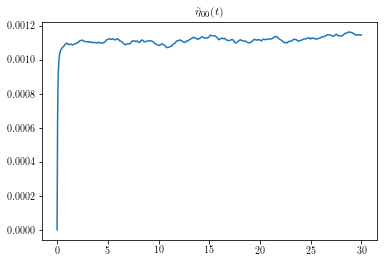

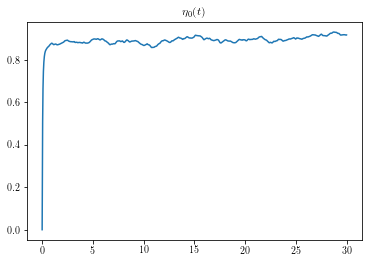

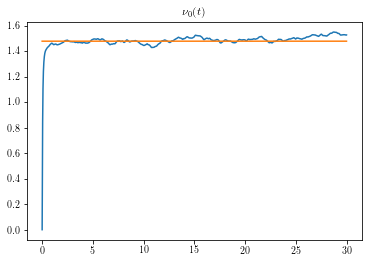

In [32]:
x = np.arange(0,nStepsLong * dtStress, dtStress)
plt.plot(x,Eta00t)
plt.title(r'$\tilde{\eta}_{00}(t)$')
plt.show()
plt.plot(x,Eta0t)
plt.title(r'$\eta_{0}(t)$')
plt.show()
plt.plot(x,KinVisc0t)
plt.plot(x, 1.48*np.ones(nStepsLong))
plt.title(r'$\nu_{0}(t)$')
plt.show()

#### Save files

# 3. PREDICTIONS 

From the figures we may considerer that $\tilde{\Lambda}(t)$ has a plateau. We select $\tau=0.2$ as the best compromise satisfaying that $\Lambda(t)$ has attained its constant value. Therefore 

$C^{predict}(t) = exp[-\Lambda(\tau)·(t-\tau)]C(\tau)$ 

## 3.1. Compute predictions

In [70]:
tau = 0.2
v0 = 1.5
nStepsPred = 2500
CtPredict      = np.zeros((nNodes, nNodes, nStepsPred))
CtPredictLocal = np.zeros((nNodes, nNodes, nStepsPred))
for k in range(nStepsPred):
    t = k * dt
    CtPredict[:,:,k]      = expm(- Lambdat[:,:,step(tau)] * (t - tau)).dot(Ct[:,:,step(tau)])
    CtPredictLocal[:,:,k] = expm(v0 * Laplacian * (t - tau)).dot(Ct[:,:,step(tau)])

## 3.2. Plot $C(t)$ and the predictions

/home/diego/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


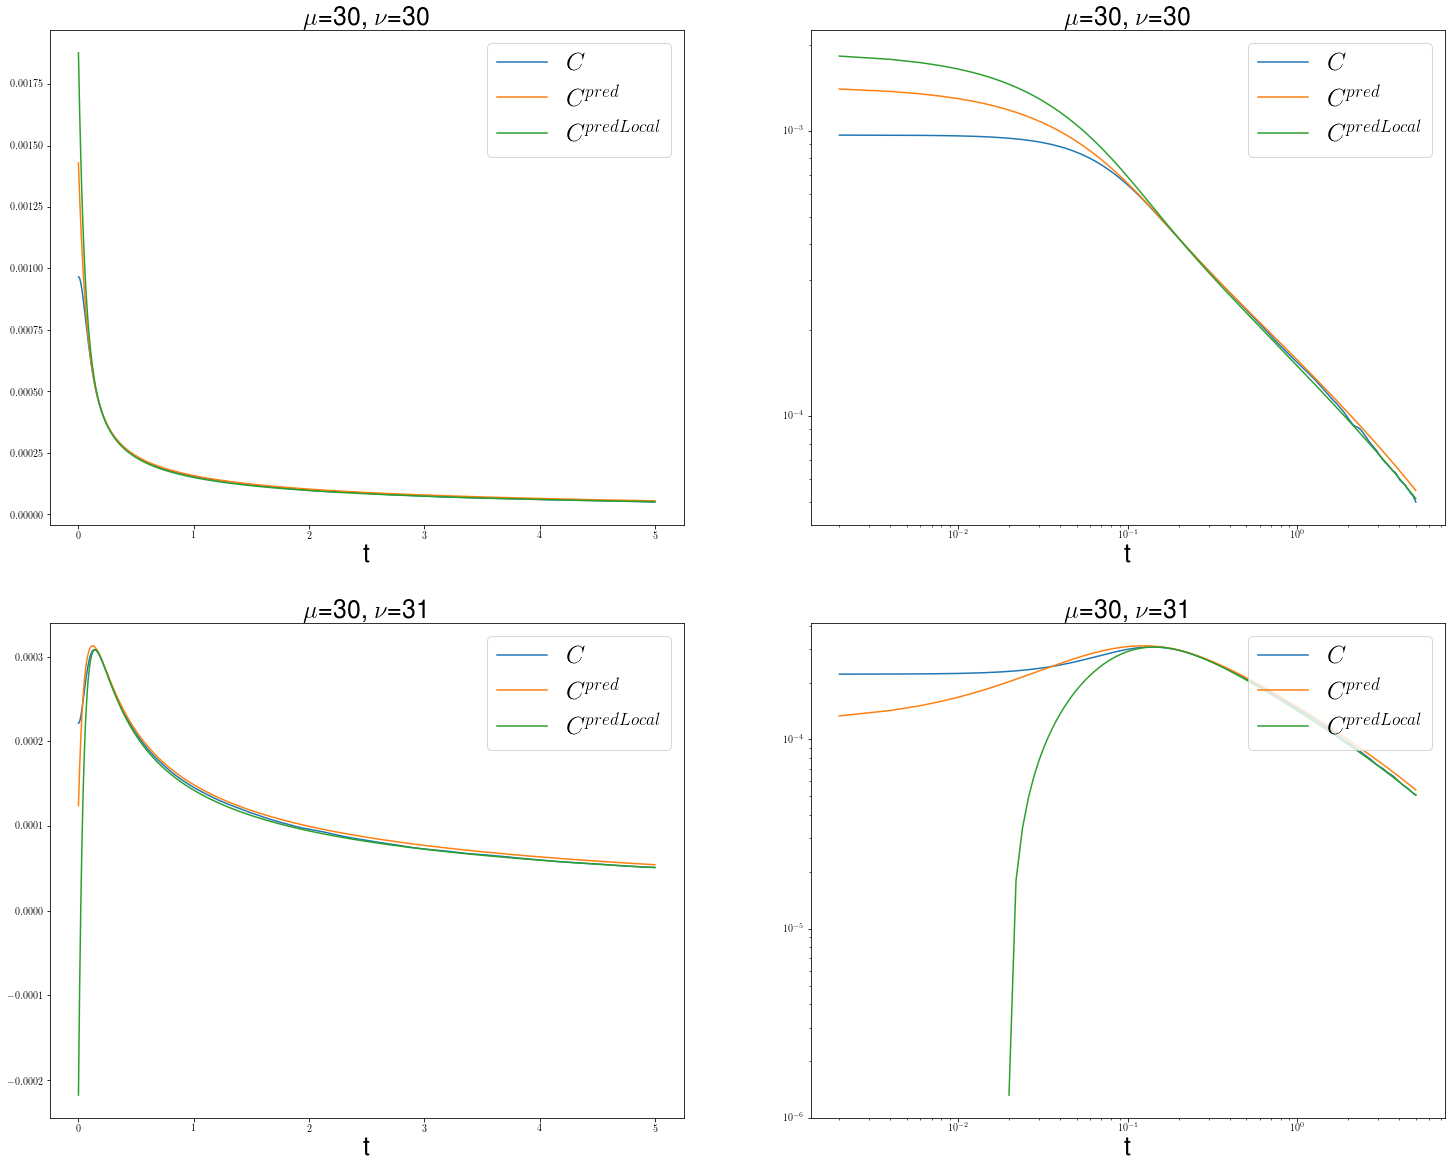

In [72]:
x = np.arange(0, nStepsPred * dt, dt)
plt.figure(1, figsize=(25,20))

plt.subplot(2,2,1)
plt.plot(x, Ct_mu30nu30[:nStepsPred], label='$C$')
plt.plot(x, CtPredict[29,29,:], label=r'$C^{pred}$')
plt.plot(x, CtPredictLocal[29,29,:], label=r'$C^{predLocal}$')
plt.title(r'$\mu$=30, $\nu$=30',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(2,2,2)
plt.loglog(x, Ct_mu30nu30[:nStepsPred], label='$C$')
plt.loglog(x, CtPredict[29,29,:], label=r'$C^{pred}$')
plt.loglog(x, CtPredictLocal[29,29,:], label=r'$C^{predLocal}$')
plt.title(r'$\mu$=30, $\nu$=30',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(2,2,3)
plt.plot(x, Ct_mu30nu31[:nStepsPred], label='$C$')
plt.plot(x, CtPredict[29,30,:], label=r'$C^{pred}$')
plt.plot(x, CtPredictLocal[29,30,:], label=r'$C^{predLocal}$')
plt.title(r'$\mu$=30, $\nu$=31',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(2,2,4)
plt.loglog(x, Ct_mu30nu31[:nStepsPred], label='$C$')
plt.loglog(x, CtPredict[29,30,:], label=r'$C^{pred}$')
plt.loglog(x, CtPredictLocal[29,30,:], label=r'$C^{predLocal}$')
plt.title(r'$\mu$=30, $\nu$=31',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.show()

#### Save files

# FIGURES - THESIS